## Cox-CC
In this notebook we will train the [Cox-CC method](http://jmlr.org/papers/volume20/18-424/18-424.pdf). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import torch
import torchtuples as tt

from pycox.models import CoxCC
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

### Dataset
Loading the dataset

In [3]:
df = pd.read_csv('./../datasets/arhv_prepro_5.0.csv')
df

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,F36,F37,F38,F39,F40,F41,F42,F43,event,time
0,0,0,1.0,1.0,0,0,0,0,0,0,...,0.104192,0.023926,1.305501,0.260649,0.122838,-0.060748,1.227461,-0.033476,0,21.0
1,0,40,2.0,1.0,1,0,0,2,0,0,...,0.187715,0.151417,0.626269,0.132299,0.251000,0.013268,-0.292335,-0.006962,0,22.0
2,0,18,2.0,1.0,0,0,0,0,0,0,...,0.385539,0.336895,1.361841,0.594791,0.949946,-0.011401,-1.925450,-0.017829,0,22.0
3,19,7,0.0,1.0,0,0,0,0,0,0,...,0.596548,0.407431,1.593357,0.224175,0.643866,0.031109,-0.442274,-0.027099,1,14.0
4,19,0,2.0,1.0,0,0,0,0,0,0,...,0.123080,0.117009,0.793149,0.381961,0.942754,0.003329,-0.745527,-0.009753,1,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6376,18,16,1.0,0.0,0,0,0,1,0,0,...,0.190463,0.168681,1.046977,0.091520,0.093166,-0.013568,-2.566817,-0.022228,1,9.0
6377,13,13,3.0,0.0,0,0,0,1,0,0,...,0.298466,0.133987,0.314466,0.145075,0.717814,0.065671,-0.155346,-0.015047,1,12.0
6378,11,11,1.0,0.0,0,0,0,1,0,0,...,0.124445,0.065487,0.977181,0.165864,0.017639,-0.008573,-1.151375,-0.043251,1,9.0
6379,9,5,1.0,0.0,0,0,0,0,0,0,...,0.000000,0.000000,0.522243,0.152878,-0.100963,-0.010897,-1.877954,-0.019716,1,15.0


In [4]:
df_train = df
df_test = df.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

print(f"Train dataset stats: {df_train.shape}, Validation datasets stats: {df_val.shape}, Test dataset stats: {df_test.shape}")

Train dataset stats: (4084, 45), Validation datasets stats: (1021, 45), Test dataset stats: (1276, 45)


In [5]:
df_train.head()

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,F36,F37,F38,F39,F40,F41,F42,F43,event,time
0,0,0,1.0,1.0,0,0,0,0,0,0,...,0.104192,0.023926,1.305501,0.260649,0.122838,-0.060748,1.227461,-0.033476,0,21.0
1,0,40,2.0,1.0,1,0,0,2,0,0,...,0.187715,0.151417,0.626269,0.132299,0.251000,0.013268,-0.292335,-0.006962,0,22.0
2,0,18,2.0,1.0,0,0,0,0,0,0,...,0.385539,0.336895,1.361841,0.594791,0.949946,-0.011401,-1.925450,-0.017829,0,22.0
3,19,7,0.0,1.0,0,0,0,0,0,0,...,0.596548,0.407431,1.593357,0.224175,0.643866,0.031109,-0.442274,-0.027099,1,14.0
9,17,0,1.0,1.0,0,0,0,1,0,0,...,0.184629,0.098159,0.508884,0.184394,-0.056303,-0.022431,-3.495778,-0.031419,1,11.0


### Feature transforms

In [6]:
from sklearn.compose import ColumnTransformer
cols = df_train.columns.tolist()
cols.remove('event')
cols.remove('time')

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), cols)],
    remainder='passthrough',
    verbose_feature_names_out=False
)

x_train = preprocessor.fit_transform(df_train).astype('float32')
x_val = preprocessor.transform(df_val).astype('float32')
x_test = preprocessor.transform(df_test).astype('float32')

In [7]:
get_target = lambda df: (df['time'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)
val.shapes()

((1021, 45), ((1021,), (1021,)))

With TupleTree (the results of tt.tuplefy) we can easily repeat the validation dataset multiple times. This will be useful for reduce the variance of the validation loss, as the validation loss of CoxCC is not deterministic.

In [8]:
val.repeat(2).cat().shapes()

((2042, 45), ((2042,), (2042,)))

### Neural net
We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

In [9]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias)

### Training the model
To train the model we need to define an optimizer. You can choose any torch.optim optimizer, but here we instead use one from tt.optim as it has some added functionality. We use the Adam optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with model.lr_finder.

In [10]:
model = CoxCC(net, tt.optim.Adam)

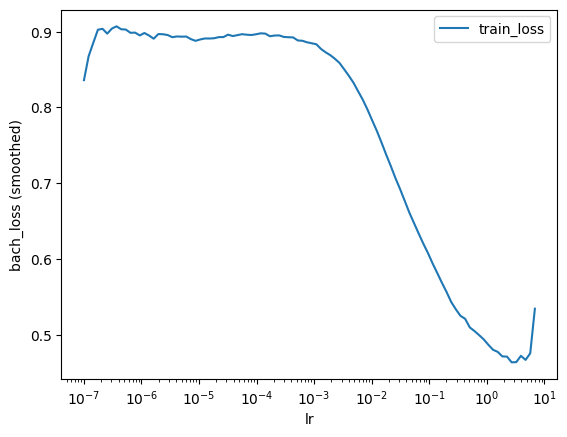

In [11]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [12]:
lrfinder.get_best_lr()

np.float64(0.2718588242732959)

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [13]:
model.optimizer.set_lr(0.01)

We include the EarlyStopping callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [14]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [15]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val.repeat(10).cat())

0:	[0s / 0s],		train_loss: 0.5434,	val_loss: 0.2154
1:	[0s / 0s],		train_loss: 0.2072,	val_loss: 0.1223
2:	[0s / 0s],		train_loss: 0.1242,	val_loss: 0.0960
3:	[0s / 0s],		train_loss: 0.0906,	val_loss: 0.0893
4:	[0s / 0s],		train_loss: 0.0868,	val_loss: 0.0706
5:	[0s / 0s],		train_loss: 0.0788,	val_loss: 0.0667
6:	[0s / 0s],		train_loss: 0.0702,	val_loss: 0.0652
7:	[0s / 0s],		train_loss: 0.0601,	val_loss: 0.0623
8:	[0s / 0s],		train_loss: 0.0667,	val_loss: 0.0540
9:	[0s / 0s],		train_loss: 0.0706,	val_loss: 0.0542
10:	[0s / 0s],		train_loss: 0.0573,	val_loss: 0.0582
11:	[0s / 0s],		train_loss: 0.0630,	val_loss: 0.0621
12:	[0s / 0s],		train_loss: 0.0613,	val_loss: 0.0480
13:	[0s / 0s],		train_loss: 0.0542,	val_loss: 0.0466
14:	[0s / 0s],		train_loss: 0.0542,	val_loss: 0.0529
15:	[0s / 0s],		train_loss: 0.0544,	val_loss: 0.0444
16:	[0s / 0s],		train_loss: 0.0420,	val_loss: 0.0438
17:	[0s / 0s],		train_loss: 0.0532,	val_loss: 0.0474
18:	[0s / 0s],		train_loss: 0.0528,	val_loss: 0.0485
19:

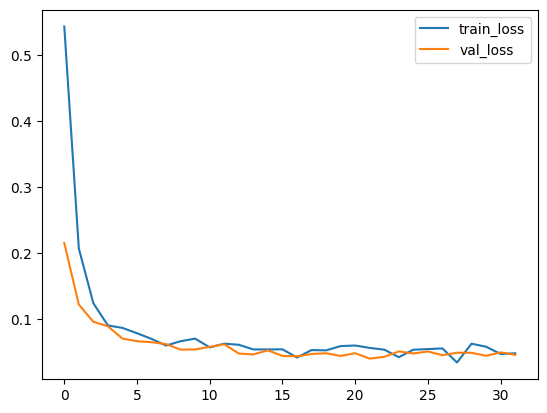

In [16]:
_ = log.plot()

We can get the partial log-likelihood

In [17]:
model.partial_log_likelihood(*val).mean()

np.float32(-3.8156757)

### Prediction
For evaluation we first need to obtain survival estimates for the test set. This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as `CoxCC` is semi-parametric, we first need to get the non-parametric baseline hazard estimates with compute_baseline_hazards.

Note that for large datasets the sample argument can be used to estimate the baseline hazard on a subset.

In [18]:
_ = model.compute_baseline_hazards()

In [19]:
surv = model.predict_surv_df(x_test)

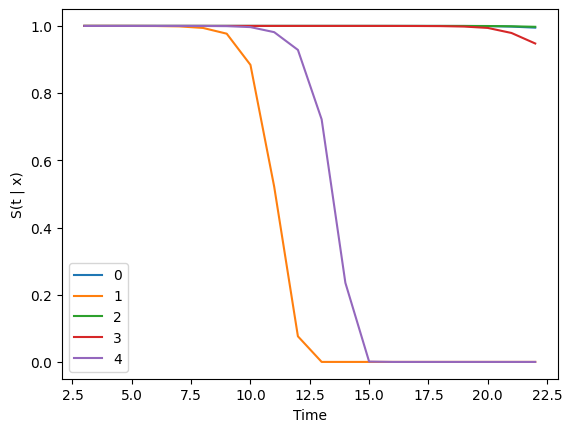

In [20]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

### Evaluation
We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [21]:
#parche por incompatibilidad
import scipy.integrate
if not hasattr(scipy.integrate, 'simps'):
    scipy.integrate.simps = scipy.integrate.simpson

In [22]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [36]:
joblib.dump(ev, './cox_cc_models/coxcc_evaluation.joblib')

['./cox_cc_models/coxcc_evaluation.joblib']

In [23]:
ev.concordance_td()

/media/datos/WORKSPACE/DOCTORADO/cdm_prototype/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


0.9803391355928737

In [37]:
loaded_eval = joblib.load("./cox_cc_models/coxcc_evaluation.joblib")
loaded_eval.concordance_td()

0.9803391355928737

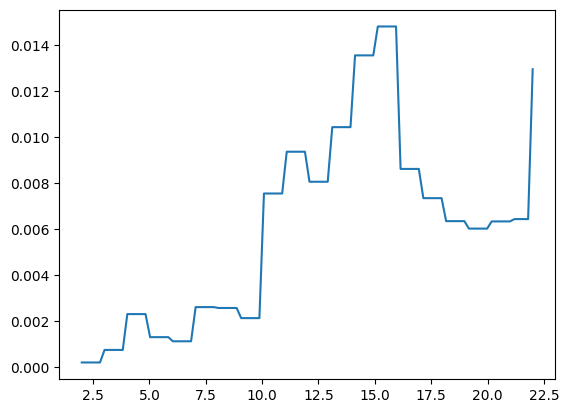

In [24]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [25]:
ev.integrated_brier_score(time_grid)

np.float64(0.005963912881270328)

In [26]:
ev.integrated_nbll(time_grid)

np.float64(0.020372368559617063)

### Saving model on disk

In [27]:
import joblib
joblib.dump(preprocessor, './cox_cc_models/cox_cc_preprocessor.pkl')
# joblib.dump(model, './cox_cc_models/cox_cc_model.joblib')

['./cox_cc_models/cox_cc_preprocessor.pkl']

In [28]:
torch.save(model.net.state_dict(), './cox_cc_models/cox_cc_modelo_weights.pt')

In [29]:
baseline_hazards = model.baseline_hazards_
joblib.dump(baseline_hazards, './cox_cc_models/cox_cc_baseline_hazards.joblib')

['./cox_cc_models/cox_cc_baseline_hazards.joblib']

### Hacer nuevas predicciones a partir de los modelos salvados

In [30]:
loaded_preprocessor = joblib.load('./cox_cc_models/cox_cc_preprocessor.pkl')
loaded_baseline_hazards = joblib.load('./cox_cc_models/cox_cc_baseline_hazards.joblib')
loaded_model_net_state_dict = torch.load('./cox_cc_models/cox_cc_modelo_weights.pt')

In [31]:
to_predict = pd.read_csv('./../datasets/to_predict.csv')
X_preprocessed = loaded_preprocessor.transform(to_predict).astype('float32')
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns = to_predict.columns)
X_preprocessed_df


,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,F36,F37,F38,F39,F40,F41,F42,F43,event,time
0,1.730398,-0.134682,1.455051,0.046996,-0.307115,-0.038044,5.761222,-0.937135,-0.027113,-0.025561,...,0.545213,0.837517,1.293277,0.166433,0.492885,0.867182,0.657975,0.871417,1.0,15.0
1,-0.002623,-0.452034,-1.096442,0.046996,-0.307115,-0.038044,-0.174906,-0.937135,-0.027113,-0.025561,...,-0.321625,-0.142268,-0.678501,-0.124908,-0.517465,-0.240817,-0.104628,0.003661,1.0,14.0
2,1.415303,-0.452034,0.179304,0.046996,-0.307115,-0.038044,-0.174906,-0.937135,-0.027113,-0.025561,...,-1.278276,-1.409961,-2.022630,2.644533,0.579499,-1.615998,1.420664,0.565209,1.0,14.0


In [32]:
net = tt.practical.MLPVanilla(
    to_predict.shape[1],
    [32, 32],
    1,
    batch_norm = True,
    dropout = 0.1,
    output_bias=False
)
net.load_state_dict(loaded_model_net_state_dict)
model_loaded = CoxCC(net, tt.optim.Adam)

In [33]:
log_risk = model_loaded.predict(X_preprocessed)
print(f"Log risk: {log_risk}")

risk = np.exp(log_risk)
print(f"Risk: {risk}")

Log risk: [[3.135963 ]
 [3.9940863]
 [3.8904247]]
Risk: [[23.01078 ]
 [54.276222]
 [48.931667]]


In [34]:
model_loaded.baseline_hazards_ = loaded_baseline_hazards
model_loaded.baseline_cumulative_hazards_ = model_loaded.compute_baseline_cumulative_hazards(
    set_hazards=False, 
    baseline_hazards_=loaded_baseline_hazards
)

surv = model_loaded.predict_surv_df(X_preprocessed)
surv

,0,1,2
duration,,,
3.0,1.000000e+00,9.999999e-01,9.999999e-01
4.0,9.999998e-01,9.999996e-01,9.999996e-01
5.0,9.999992e-01,9.999981e-01,9.999983e-01
6.0,9.999975e-01,9.999940e-01,9.999946e-01
7.0,9.999887e-01,9.999733e-01,9.999759e-01
8.0,9.999511e-01,9.998846e-01,9.998960e-01
9.0,9.998091e-01,9.995499e-01,9.995942e-01
10.0,9.989946e-01,9.976301e-01,9.978633e-01
11.0,9.947040e-01,9.875532e-01,9.887719e-01
